<a href="https://colab.research.google.com/github/ArifAygun/CustomerEye/blob/main/Company_Review_Analysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### IMPORT LIBRARIES AND DATASET

In [1]:
!pip install pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 25.8 MB/s eta 0:00:00


In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import pycountry

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive/')

# Change directory to the analysis folder
%cd /content/drive/My Drive/Analysis_1/

# Read CSV files into DataFrames
df1 = pd.read_csv('Freedom_Debt_Relief.csv')
df2 = pd.read_csv('Millennium_Trust.csv')
df3 = pd.read_csv('Advance_America.csv')

Mounted at /content/drive/
/content/drive/My Drive/Analysis_1


### DATA PREPROCESSING

In [4]:
print(df1.info())
print(df2.info())
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39078 entries, 0 to 39077
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Reviewer Name    39068 non-null  object
 1   Reviews Count    39078 non-null  object
 2   Country Code     39078 non-null  object
 3   Experience Date  39078 non-null  object
 4   Rating           39078 non-null  int64 
 5   Review Date      39078 non-null  object
 6   Review Title     39074 non-null  object
 7   Review Text      34241 non-null  object
 8   Reply Date       37731 non-null  object
 9   Reply Text       37731 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39328 entries, 0 to 39327
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Reviewer Name    39309 non-null  object
 1   Reviews Count    39328 non-null  object
 2   Co

In [5]:
# Convert 'Experience Date' to datetime format
df1['Experience Date'] = pd.to_datetime(df1['Experience Date'])
df2['Experience Date'] = pd.to_datetime(df2['Experience Date'])
df3['Experience Date'] = pd.to_datetime(df3['Experience Date'])

# Filter data for the years 2021, 2022, and 2023
df1_filtered = df1[df1['Experience Date'].dt.year.isin([2021, 2022, 2023])]
df2_filtered = df2[df2['Experience Date'].dt.year.isin([2021, 2022, 2023])]
df3_filtered = df3[df3['Experience Date'].dt.year.isin([2021, 2022, 2023])]

# Define the threshold for random sampling
threshold = 1000

# Check if data points are greater than 1000 before sampling
if len(df1_filtered) > threshold:
    df1_sampled = df1_filtered.sample(n=threshold, random_state=42)
else:
    df1_sampled = df1_filtered

if len(df2_filtered) > threshold:
    df2_sampled = df2_filtered.sample(n=threshold, random_state=42)
else:
    df2_sampled = df2_filtered

if len(df3_filtered) > threshold:
    df3_sampled = df3_filtered.sample(n=threshold, random_state=42)
else:
    df3_sampled = df3_filtered

In [6]:
print(df1_sampled.info())
print(df2_sampled.info())
print(df3_sampled.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 9956 to 8651
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Reviewer Name    1000 non-null   object        
 1   Reviews Count    1000 non-null   object        
 2   Country Code     1000 non-null   object        
 3   Experience Date  1000 non-null   datetime64[ns]
 4   Rating           1000 non-null   int64         
 5   Review Date      1000 non-null   object        
 6   Review Title     1000 non-null   object        
 7   Review Text      884 non-null    object        
 8   Reply Date       999 non-null    object        
 9   Reply Text       999 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 85.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 22354 to 423
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------     

In [14]:
print(df1_sampled.head())
print(df2_sampled.head())
print(df3_sampled.head())

         Reviewer Name Reviews Count Country Code Experience Date  Rating  \
9956   Georges Darmani       1review           US      2022-01-21       1   
6061               LSR       1review           US      2023-06-22       4   
34135    Jason Gilston       1review           US      2022-01-03       5   
5222   Rebecca Redding       1review           US      2023-02-16       5   
36597    Debra Hankins       1review           US      2021-03-23       5   

        Review Date                             Review Title  \
9956   Jan 21, 2022       I don’t have to explain the worst…   
6061   Jul 10, 2023                  All went smooth, except   
34135   Jan 3, 2022  Very easy to navigate and very helpful.   
5222   Sep 25, 2023  The process is clear and they check in…   
36597  Mar 23, 2021         Great job y’all are doing for me   

                                             Review Text  \
9956   I don’t have to explain the worst experience e...   
6061   All went smooth, except f

In [20]:
# Define a list of dataframes
dataframes = [df1_sampled, df2_sampled, df3_sampled]

for i, df in enumerate(dataframes, start=1):
    # Filter the DataFrame based on 'updated' text in the 'Review Date' column
    updated_reviews = df[df['Review Date'].str.contains('updated', case=False, na=False)].copy()

    # Get the number of data points containing 'updated'
    num_updated_reviews = len(updated_reviews)
    print(f"\nDataFrame {i}:")
    print(f"Number of data points containing 'updated': {num_updated_reviews}")

    # Display the data points with 'updated' text in the 'Review Date' column and the new 'Updated_Date' column
    print(updated_reviews[['Review Date']])



DataFrame 1:
Number of data points containing 'updated': 26
                Review Date
35591  Updated Jun 16, 2021
8794   Updated Aug 12, 2022
5647   Updated Aug 21, 2023
8098   Updated Nov 28, 2022
34504  Updated Oct 18, 2021
36589   Updated Apr 6, 2021
34392  Updated Nov 11, 2021
36641  Updated Mar 26, 2021
34766  Updated Sep 10, 2021
34836   Updated Sep 2, 2021
6954    Updated May 1, 2023
37390   Updated Feb 2, 2021
35345  Updated Jul 14, 2021
34488  Updated Oct 21, 2021
5518   Updated Sep 14, 2023
9147   Updated Jun 17, 2022
8149   Updated Nov 17, 2022
7884   Updated Dec 30, 2022
36613  Updated Mar 23, 2021
5503   Updated Aug 31, 2023
5604   Updated Aug 22, 2023
9721   Updated Mar 26, 2022
5445    Updated Sep 6, 2023
35537  Updated Jun 22, 2021
5742   Updated Aug 10, 2023
9860   Updated Feb 11, 2022

DataFrame 2:
Number of data points containing 'updated': 19
                Review Date
24723  Updated Jul 14, 2021
28131  Updated Feb 24, 2021
26474  Updated Apr 28, 2021
24727  Upd

In [ ]:
df.head()

,Reviewer Name,Reviews Count,Country Code,Experience Date,Rating,Review Date,Review Title,Review Text,Reply Date,Reply Text
0,Andrea Sciotti,2reviews,US,"December 04, 2019",5,"Dec 4, 2019",Working on a better future,NaN,"Reply from Freedom Debt ReliefDec 4, 2019","Hello, Andrea, thank you for your review! We w..."
1,Wendy Sicard,1review,US,"December 04, 2019",5,"Dec 4, 2019",Was very helpful,NaN,"Reply from Freedom Debt ReliefDec 4, 2019","Hello, Wendy, thank you for your review! We wo..."
2,Freida Towe,1review,US,"December 04, 2019",5,"Dec 4, 2019",Very polite and kind,Very polite and kind. Did what I asked immedia...,"Reply from Freedom Debt ReliefDec 4, 2019","Thank you very much, Freida! We truly care abo..."
3,Jabrea Herron,1review,US,"December 04, 2019",5,"Dec 4, 2019",Great customer service,There wasn't a long wait time . The representa...,"Reply from Freedom Debt ReliefDec 5, 2019","Jabrea, We are so happy to hear that you are h..."
4,William Lutz,2reviews,US,"December 04, 2019",5,"Dec 4, 2019",Needed an answer to a question…,Needed an answer to a question concerning a pa...,"Reply from Freedom Debt ReliefDec 4, 2019","Hello William, thank you for sharing your expe..."


In [ ]:
# Filter the DataFrame based on 'updated' text in the 'Review Date' column
updated_reviews = df[df['Review Date'].str.contains('updated', case=False, na=False)]

# Get the number of data points containing 'updated'
num_updated_reviews = len(updated_reviews)
print(f"Number of data points containing 'updated': {num_updated_reviews}")

# Display the data points with 'updated' text in the 'Review Date' column
print(updated_reviews)

Number of data points containing 'updated': 698
              Reviewer Name Reviews Count Country Code     Experience Date  \
9             Jacey Roncali      3reviews           US   December 03, 2019   
69                    Emily      3reviews           US   November 28, 2019   
106           James Perkins      4reviews           US   November 26, 2019   
109             Wilda Valle       1review           US   November 26, 2019   
209            Pat Kilbourn      2reviews           US   November 22, 2019   
...                     ...           ...          ...                 ...   
38837  Oscar Bernales Simon       1review           US  September 29, 2020   
38895       Victoria Watson      3reviews           US  September 24, 2020   
38909                Sylvia      2reviews           US  September 22, 2020   
38921              Mai Vang      2reviews           AU  September 20, 2020   
39052       bridget swenson       1review           US     August 31, 2020   

       Rating  

In [ ]:
# Remove "review" and "reviews" from the values in the "Reviews Count" column
df['Reviews Count'] = df['Reviews Count'].str.replace('reviews', '').str.replace('review', '')

# Convert the "Reply Date" column to a string data type
df['Reply Date'] = df['Reply Date'].astype(str)

# Remove "Reply from Freedom Debt Relief" from the "Reply Date" column in the existing DataFrame
df['Reply Date'] = df['Reply Date'].str.replace("Reply from Freedom Debt Relief", "")

# Convert 'Experience Date', 'Review Date', 'Reply Date' columns to date
df[['Experience Date', 'Review Date', 'Reply Date']] = df[['Experience Date', 'Review Date', 'Reply Date']].apply(pd.to_datetime, errors='coerce')

# Convert "Reviews Count" column to integer
df['Reviews Count'] = pd.to_numeric(df['Reviews Count'], errors='coerce').astype('Int64')

In [ ]:
# Missing values
missing_values = df.isnull().sum()
print(missing_values)

Reviewer Name        10
Reviews Count         0
Country Code          0
Experience Date       0
Rating                0
Review Date         791
Review Title          4
Review Text        4837
Reply Date         1684
Reply Text         1347
dtype: int64


In [ ]:
# Drop rows with missing values in specific columns
df.dropna(subset=['Reviewer Name', 'Experience Date', 'Rating', 'Review Date', 'Review Title', 'Review Text'], inplace=True)

In [ ]:
# Add a new column with country names
df['Country Name'] = df['Country Code'].apply(lambda code: pycountry.countries.get(alpha_2=code).name if pycountry.countries.get(alpha_2=code) else None)

# Replace the existing 'Country Name' column with the updated one
df['Country Name'] = df['Country Name']

# Display the updated DataFrame
df.head().T

,2,3,4,5,6
Reviewer Name,Freida Towe,Jabrea Herron,William Lutz,John Novotny,Maria S
Reviews Count,1,1,2,1,1
Country Code,US,US,US,US,US
Experience Date,2019-12-04 00:00:00,2019-12-04 00:00:00,2019-12-04 00:00:00,2019-12-04 00:00:00,2019-12-04 00:00:00
Rating,5,5,5,5,1
Review Date,2019-12-04 00:00:00,2019-12-04 00:00:00,2019-12-04 00:00:00,2019-12-04 00:00:00,2019-12-04 00:00:00
Review Title,Very polite and kind,Great customer service,Needed an answer to a question…,i had a question,This company charges outrageous…
Review Text,Very polite and kind. Did what I asked immedia...,There wasn't a long wait time . The representa...,Needed an answer to a question concerning a pa...,I got my answer right away . very professional.,This company charges outrageous settlement fee...
Reply Date,2019-12-04 00:00:00,2019-12-05 00:00:00,2019-12-04 00:00:00,2019-12-04 00:00:00,2019-12-04 00:00:00
Reply Text,"Thank you very much, Freida! We truly care abo...","Jabrea, We are so happy to hear that you are h...","Hello William, thank you for sharing your expe...","John, thank you for your review. We strive to ...","We apologize, Ms. Maria, for any frustrations ..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33454 entries, 2 to 39077
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Reviewer Name    33454 non-null  object        
 1   Reviews Count    33454 non-null  Int64         
 2   Country Code     33454 non-null  object        
 3   Experience Date  33454 non-null  datetime64[ns]
 4   Rating           33454 non-null  int64         
 5   Review Date      33454 non-null  datetime64[ns]
 6   Review Title     33454 non-null  object        
 7   Review Text      33454 non-null  object        
 8   Reply Date       31901 non-null  datetime64[ns]
 9   Reply Text       32135 non-null  object        
 10  Country Name     33454 non-null  object        
dtypes: Int64(1), datetime64[ns](3), int64(1), object(6)
memory usage: 3.1+ MB


In [ ]:
# Save the DataFrame to a CSV file
df.to_csv('cleaned1.csv', index=False)

**Unique Values**

In [ ]:
df.nunique()

Reviewer Name      27628
Reviews Count         29
Country Code          50
Experience Date     2807
Rating                 5
Review Date         2823
Review Title       28611
Review Text        33371
Reply Date          1633
Reply Text         24180
Country Name          50
dtype: int64

## RATING ANALYSIS BY COUNTRY

In [ ]:
# Number of unique countries
number_of_countries = df['Country Name'].nunique()
print("Number of unique countries:", number_of_countries)

Number of unique countries: 50


In [ ]:
# Extract unique country codes and their counts
unique_country_codes = df['Country Code'].unique()
code_counts = df['Country Code'].value_counts().reset_index()
code_counts.columns = ['Country Code', 'Number of Codes']

# Create a new DataFrame with the unique country codes and their counts
new_df = pd.DataFrame({'Country Code': unique_country_codes})
new_df = new_df.merge(code_counts, on='Country Code', how='left')

# Sort the new DataFrame in descending order based on the 'Number of Codes' column
new_df = new_df.sort_values(by='Number of Codes', ascending=False)

# Reset the index
new_df = new_df.reset_index(drop=True)

# Display the first 10 rows with country names
first_10_copy = new_df.head(10).copy()  # Ensure you create a copy

# Map country codes to names using pycountry
first_10_copy.loc[:, 'Country Name'] = first_10_copy['Country Code'].apply(lambda code: pycountry.countries.get(alpha_2=code).name)

print(first_10_copy[['Country Code', 'Number of Codes', 'Country Name']])

  Country Code  Number of Codes    Country Name
0           US            33254   United States
1           PR               69     Puerto Rico
2           MX               15          Mexico
3           GU               12            Guam
4           GB                9  United Kingdom
5           CA                8          Canada
6           PH                7     Philippines
7           DE                6         Germany
8           AU                5       Australia
9           IQ                4            Iraq


In [ ]:
# Calculate the mean ratings
mean_ratings = df.groupby('Country Code')['Rating'].mean().reset_index()
mean_ratings.columns = ['Country Code', 'Mean Rating']

# Merge the mean ratings with the first_10_copy DataFrame
first_10_copy = first_10_copy.merge(mean_ratings, on='Country Code', how='left')

# If 'first_10_copy' is missing the 'Mean Rating' column, make sure to recreate it
if 'Mean Rating' not in first_10_copy.columns:
    first_10_copy['Mean Rating'] = mean_ratings['Mean Rating']

print(first_10_copy[['Country Code', 'Number of Codes', 'Country Name', 'Mean Rating']])

  Country Code  Number of Codes    Country Name  Mean Rating
0           US            33254   United States     4.591748
1           PR               69     Puerto Rico     4.608696
2           MX               15          Mexico     5.000000
3           GU               12            Guam     4.750000
4           GB                9  United Kingdom     3.555556
5           CA                8          Canada     4.875000
6           PH                7     Philippines     4.857143
7           DE                6         Germany     3.666667
8           AU                5       Australia     4.200000
9           IQ                4            Iraq     5.000000


  Country Code  Number of Codes    Country Name  Mean Rating
0           US            33254   United States     3.666667
1           PR               69     Puerto Rico     5.000000
2           MX               15          Mexico     5.000000
3           GU               12            Guam     4.200000
4           GB                9  United Kingdom     5.000000
5           CA                8          Canada     5.000000
6           PH                7     Philippines     5.000000
7           DE                6         Germany     4.500000
8           AU                5       Australia     4.875000
9           IQ                4            Iraq     5.000000


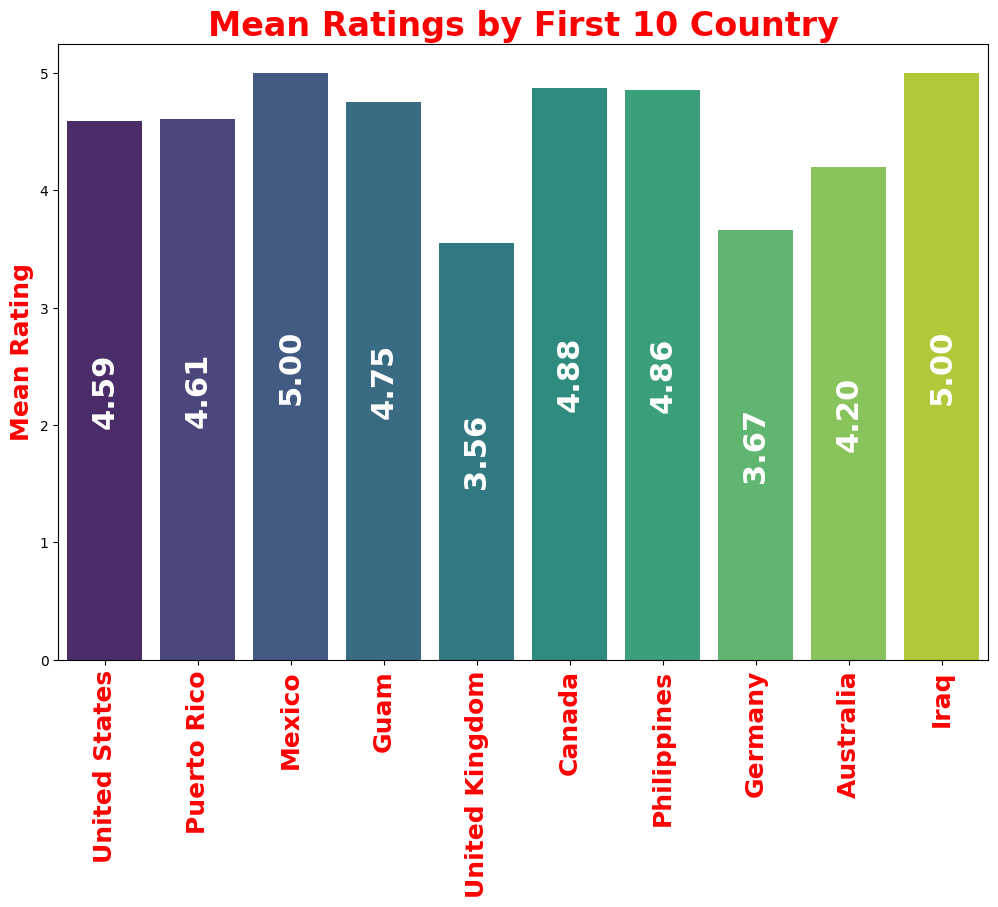

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean ratings
mean_ratings = df.groupby('Country Code')['Rating'].mean().reset_index()
mean_ratings.columns = ['Country Code', 'Mean Rating']

# Merge the mean ratings with the first_10_copy DataFrame
first_10_copy = first_10_copy.merge(mean_ratings, on='Country Code', how='left', suffixes=('_original', '_mean'))

# If 'first_10_copy' is missing the 'Mean Rating' column, make sure to recreate it
if 'Mean Rating' not in first_10_copy.columns:
    first_10_copy['Mean Rating'] = mean_ratings['Mean Rating']

# Display the DataFrame with mean ratings
print(first_10_copy[['Country Code', 'Number of Codes', 'Country Name', 'Mean Rating']])

# Bar plot for Mean Ratings by Country
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Country Name', y='Mean Rating_mean', data=first_10_copy, palette='viridis')
plt.title('Mean Ratings by First 10 Country', fontsize=24, fontweight='bold', color='red')
plt.xlabel('', fontsize=14)
plt.ylabel('Mean Rating', fontsize=18, fontweight='bold', color='red')
plt.xticks(rotation=90, fontsize=18, fontweight='bold', color='red')

# Add labels to the bars at the center of each bar
for i, val in enumerate(first_10_copy['Mean Rating_mean']):
    ax.text(i, val/2, f'{val:.2f}', ha='center', va='center', fontsize=22, fontweight='bold', color='white', rotation=90)

plt.show()

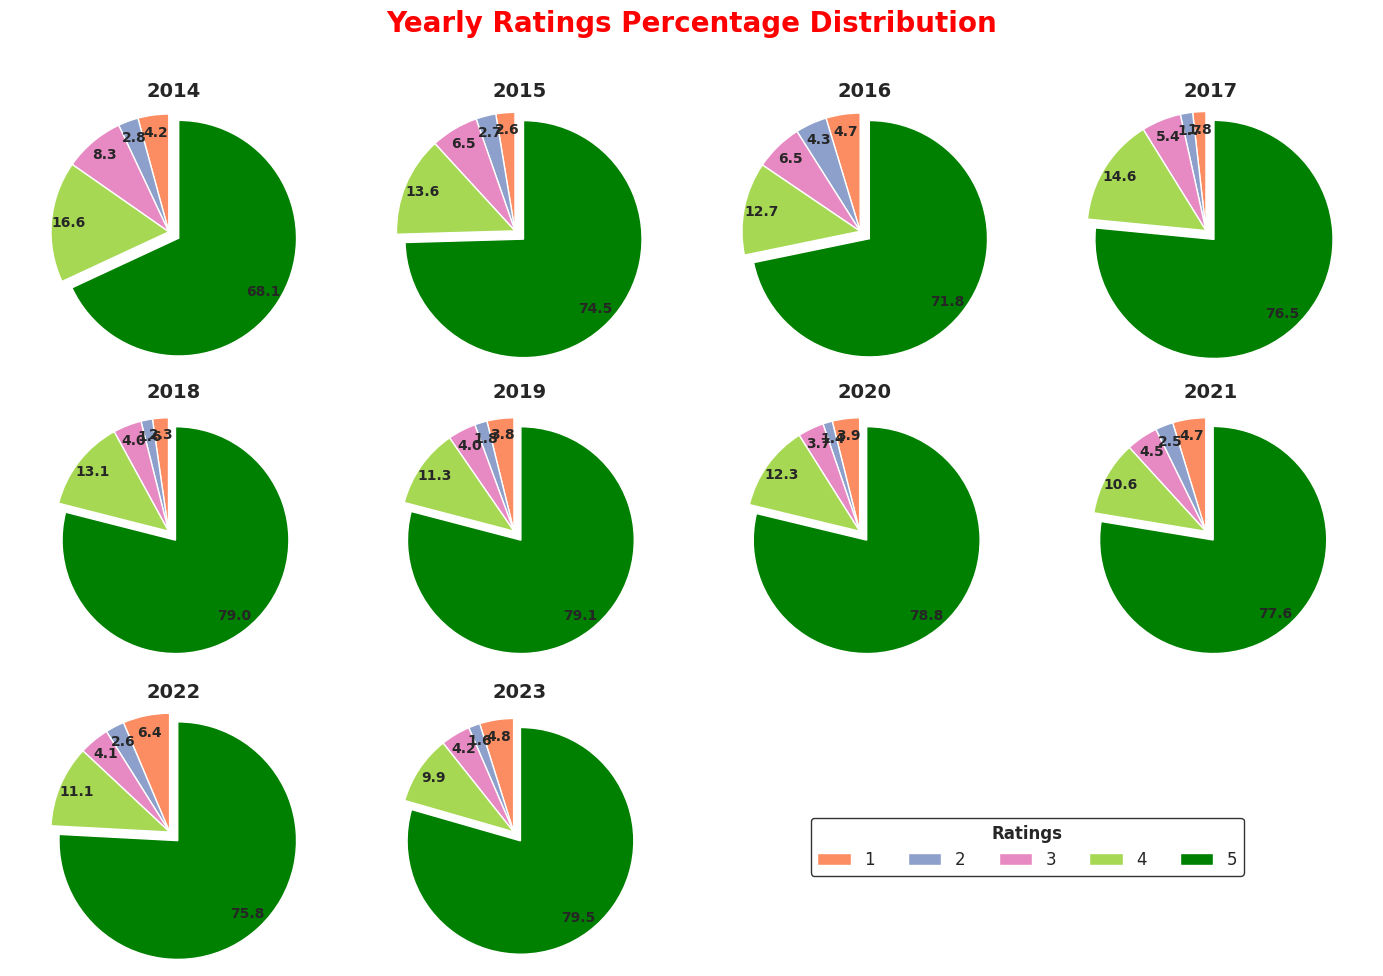

In [ ]:
# Assuming you have a DataFrame named df with a 'Review Date' column and a 'Rating' column

# Extract the year from the 'Review Date' column
df['Year'] = df['Review Date'].dt.year

# Count the occurrences of each rating for each year
yearly_rating_counts = df.groupby(['Year', 'Rating']).size().unstack(fill_value=0)

# Create a figure with separate subplots for each year
fig, axes = plt.subplots(3, 4, figsize=(14, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each year and create a pie chart
for ax, (year, ratings) in zip(axes, yearly_rating_counts.iterrows()):
    colors = plt.cm.Set2(np.arange(1, len(ratings) + 1))  # Change color palette to Set2

    # Change the color of the "5" rating to green
    colors = ['green' if rating == 5 else color for rating, color in zip(ratings.index, colors)]

    explode = tuple(0.1 if i == ratings.idxmax() else 0 for i in range(1, len(ratings) + 1))

    # Check if ratings are not all zeros
    if not ratings.eq(0).all():
        # Adjust autopct to show percentages as numbers
        ax.pie(ratings, labels=None, autopct=lambda p: f'{p:.1f}', startangle=90, colors=colors, explode=explode, pctdistance=0.85, textprops={'fontsize': 10, 'weight': 'bold'})
        ax.set_title(f'{year}', fontsize=14, weight='bold')
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    else:
        ax.axis('off')  # Turn off axis for empty subplots

# Create a legend at the lower right with a centered layout
legend = fig.legend(ratings.index, title='Ratings', loc='lower right', bbox_to_anchor=(0.9, 0.1), fontsize=12, title_fontsize=12, edgecolor='black', ncol=len(ratings.index))
legend.get_title().set_fontweight('bold')  # Set fontweight for legend title

# Add a main title above the subplots
plt.figtext(0.5, 0.96, 'Yearly Ratings Percentage Distribution', ha='center', va='center', fontsize=20, fontweight='bold', color='red')

# Remove empty subplots from the layout
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust the rect parameter to leave space for the main title

# Show the pie charts
plt.show()


## Aggregation and Grouping (yearly, quarterly, monthly):


# Yearly

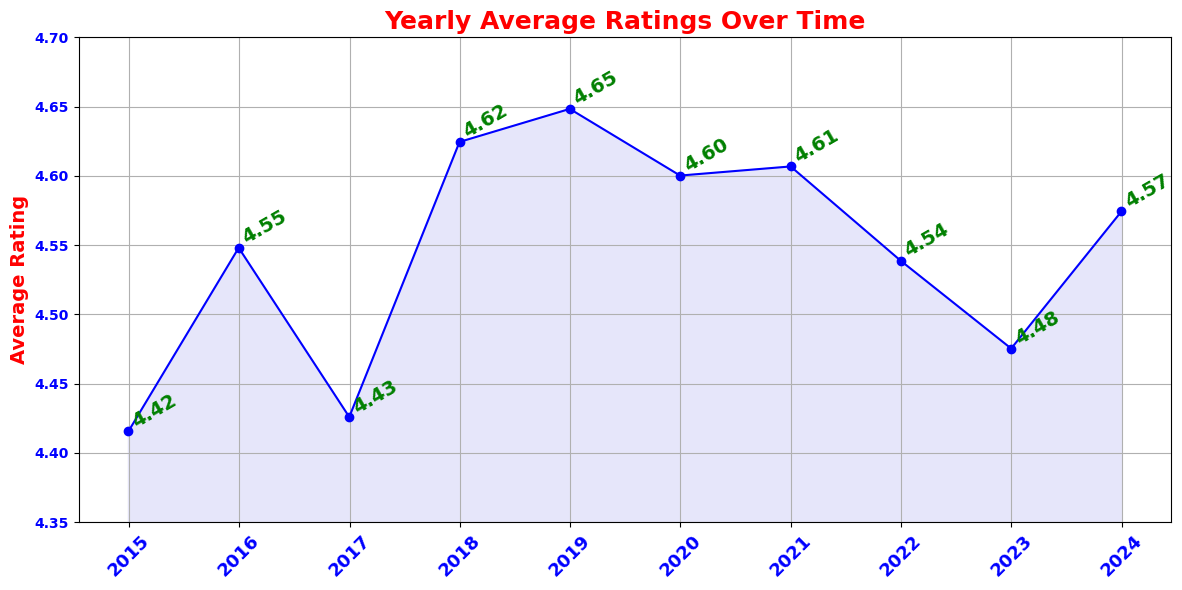

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Downsample the data by averaging ratings by year
yearly_ratings = df.resample('Y', on='Review Date')['Rating'].mean().dropna()

# Create a time series plot of downsampled ratings
plt.figure(figsize=(12, 6))

# Plot the line
plt.plot(yearly_ratings.index, yearly_ratings.values, marker='o', linestyle='-', color='b', label='Average Rating')

# Fill the area under the line with light purple
plt.fill_between(yearly_ratings.index, yearly_ratings.values, color='lavender')

# Set the y-axis range to 4 to 5
plt.ylim(4.35, 4.7)

# Add labels and title
plt.title('Yearly Average Ratings Over Time', fontsize=18, fontweight='bold', color='red')
plt.xlabel('')
plt.ylabel('Average Rating', fontsize=14, fontweight='bold', color='red')
plt.grid(True)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Make y-axis labels bold
plt.yticks(fontweight='bold', color='blue')
plt.xticks(fontweight='bold', fontsize=13, rotation=45, color='blue')

# Annotate data values on the line plot
for x, y in zip(yearly_ratings.index, yearly_ratings.values):
    plt.text(x, y, f'{y:.2f}', ha='left', va='bottom', fontsize=14, fontweight='bold', color='green', rotation=30)

# Show the plot
plt.tight_layout()
plt.show()

# Convert the downsampled ratings to a DataFrame
yearly_ratings_df = yearly_ratings.to_frame().reset_index()
yearly_ratings_df.columns = ['Year', 'Average Rating']

# Save the DataFrame to a CSV file
yearly_ratings_df.to_csv('yearly_ratings.csv', index=False)


# Quarterly

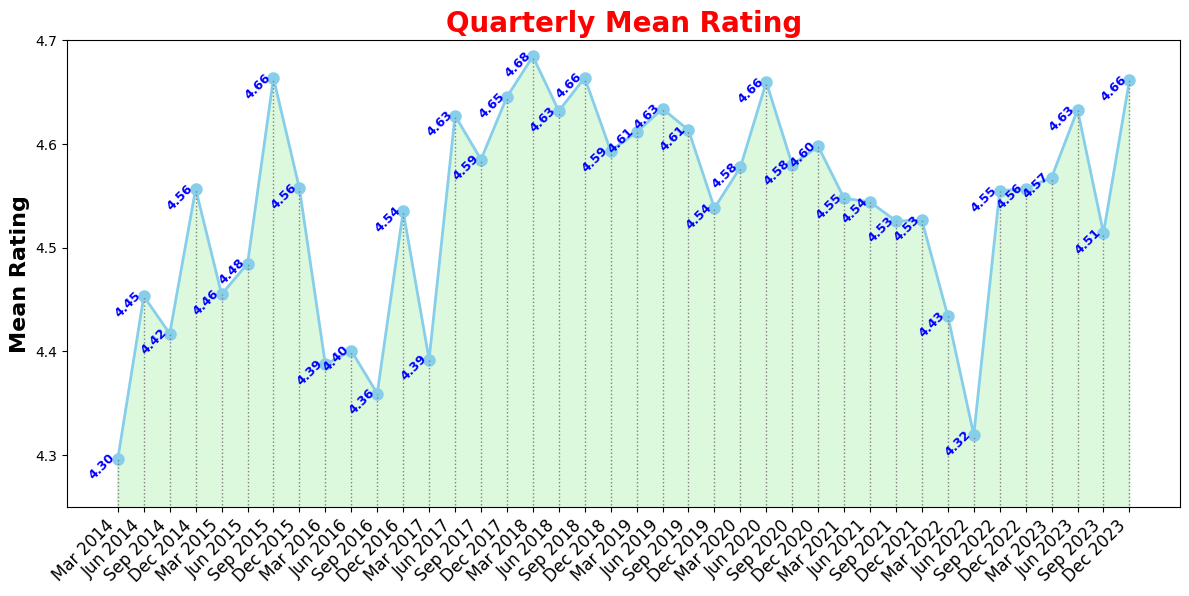

In [ ]:
import matplotlib.pyplot as plt

# Group data by quarter and calculate the mean rating for each quarter
quarterly_mean_rating = df.groupby(df['Review Date'].dt.to_period('Q')).agg({'Rating': 'mean'})

# Create a line plot for quarterly mean rating with enhanced styling
plt.figure(figsize=(12, 6))

# Plot the line
plt.plot(
    quarterly_mean_rating.index.strftime('%b %Y'),
    quarterly_mean_rating['Rating'],
    marker='o',
    color='skyblue',
    linewidth=2,
    markersize=8,
)

# Fill the area below the line with light green color
plt.fill_between(
    quarterly_mean_rating.index.strftime('%b %Y'),
    quarterly_mean_rating['Rating'],
    color='lightgreen',  # Specify the fill color as light green
    alpha=0.3,  # Adjust transparency of the fill
)

# Set the y-axis range to 4 to 5
plt.ylim(4.25, 4.7)

# Add labels and titles
plt.title('Quarterly Mean Rating', fontsize=16, fontweight='bold', color='black')  # Default title color
plt.xlabel('', fontsize=14, fontweight='bold')
plt.ylabel('Mean Rating', fontsize=16, fontweight='bold')

# Rotate x-axis labels for readability (rotate 45 degrees)
plt.xticks(rotation=45, ha="right", fontsize=12)

# Annotate data values on the line plot and draw lines to x-axis
for x, y in zip(quarterly_mean_rating.index.strftime('%b %Y'), quarterly_mean_rating['Rating']):
    plt.annotate(
        f'{y:.2f}',
        (x, y),
        textcoords='offset points',
        xytext=(0, -15),  # Adjust the y-coordinate to move labels to the bottom
        ha='right',  # Rotate 45 degrees
        fontsize=9,
        color='blue',
        fontweight='bold',
        rotation=45,  # Rotate the label
    )
    plt.vlines(x, 3.5, y, colors='gray', linestyles='dotted', lw=1)

# Show the plot
plt.tight_layout()

# Set the title font properties
title = plt.title('Quarterly Mean Rating', fontsize=20, fontweight='bold', color='red')  # Updated title color

# Show the plot
plt.show()


# Monthly

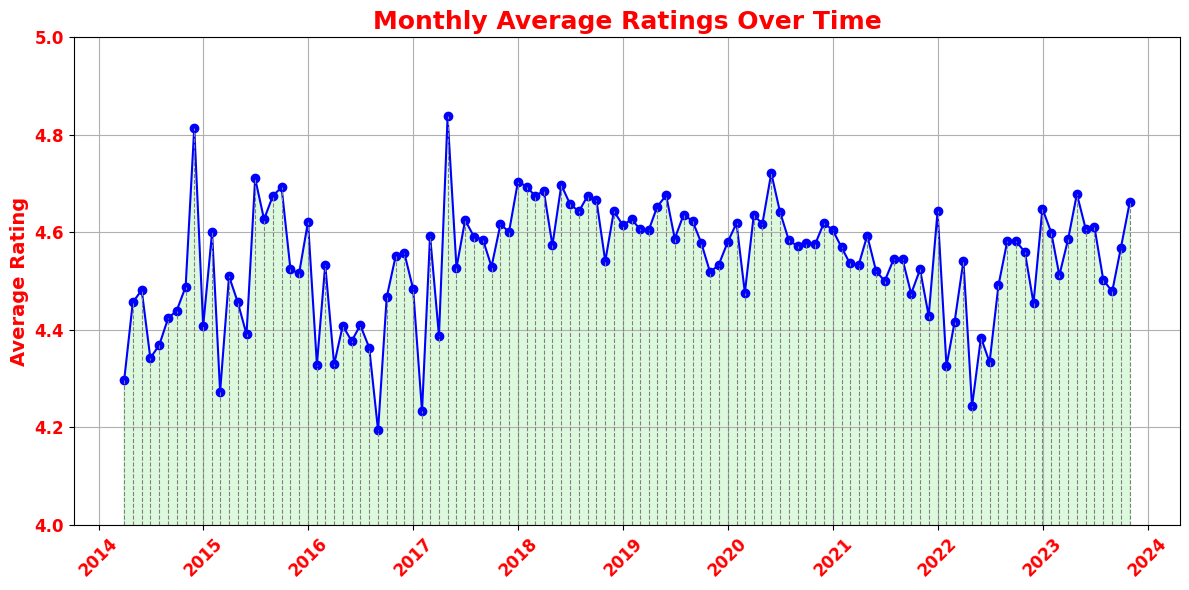

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assuming you have a DataFrame named df with a 'Review Date' column and a 'Rating' column

# Downsample the data by averaging ratings by month
monthly_ratings = df.resample('M', on='Review Date')['Rating'].mean().dropna()

# Create a time series plot of downsampled ratings
plt.figure(figsize=(12, 6))
plt.plot(monthly_ratings.index, monthly_ratings.values, marker='o', linestyle='-', color='b', label='Average Rating')
plt.fill_between(monthly_ratings.index, monthly_ratings.values, color='lightgreen', alpha=0.3)  # Fill the area under the line with light green

# Add vertical lines between x-axis and points
for date, rating in zip(monthly_ratings.index, monthly_ratings.values):
    plt.vlines(date, 4, rating, color='gray', linestyle='--', linewidth=0.8)

plt.title('Monthly Average Ratings Over Time', fontsize=18, fontweight='bold', color='red')  # Updated title color
plt.xlabel('')
plt.ylabel('Average Rating', fontsize=14, fontweight='bold', color='red')
plt.grid(True)

# Set x-axis tick locator and formatter for years only
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')  # Display years as four-digit numbers

plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)

# Customize x-axis ticks and labels
plt.xticks(fontsize=12, fontweight='bold', color='red', ha='center', rotation=45)

# Customize y-axis ticks and labels
plt.yticks(fontsize=12, fontweight='bold', color='red')

# Set the y-axis range to 4 to 5
plt.ylim(4, 5)

# Show the plot
plt.tight_layout()
plt.show()

# Convert the downsampled ratings to a DataFrame
monthly_ratings_df = monthly_ratings.to_frame().reset_index()
monthly_ratings_df.columns = ['Date', 'Average Rating']

# Save the DataFrame to a CSV file
monthly_ratings_df.to_csv('monthly_ratings.csv', index=False)


## Date-Related Calculations:




### a. Calculate Time Difference:


Calculate the time difference between two date columns. For instance, you can calculate the response time by subtracting the review date from the reply date.

In [ ]:
df['Review Response'] = df['Review Date'] - df['Experience Date']

df['Reply Response'] = df['Reply Date'] - df['Review Date']

In [ ]:
df.head()

,Reviewer Name,Reviews Count,Country Code,Experience Date,Rating,Review Date,Review Title,Review Text,Reply Date,Reply Text,Country Name,Year,Review Response,Reply Response
2,Freida Towe,1,US,2019-12-04,5,2019-12-04,Very polite and kind,Very polite and kind. Did what I asked immedia...,2019-12-04,"Thank you very much, Freida! We truly care abo...",United States,2019,0 days,0 days
3,Jabrea Herron,1,US,2019-12-04,5,2019-12-04,Great customer service,There wasn't a long wait time . The representa...,2019-12-05,"Jabrea, We are so happy to hear that you are h...",United States,2019,0 days,1 days
4,William Lutz,2,US,2019-12-04,5,2019-12-04,Needed an answer to a question…,Needed an answer to a question concerning a pa...,2019-12-04,"Hello William, thank you for sharing your expe...",United States,2019,0 days,0 days
5,John Novotny,1,US,2019-12-04,5,2019-12-04,i had a question,I got my answer right away . very professional.,2019-12-04,"John, thank you for your review. We strive to ...",United States,2019,0 days,0 days
6,Maria S,1,US,2019-12-04,1,2019-12-04,This company charges outrageous…,This company charges outrageous settlement fee...,2019-12-04,"We apologize, Ms. Maria, for any frustrations ...",United States,2019,0 days,0 days


### b. Extract Date Components:

Extract specific components from the date, such as year, month, day, or weekday.

In [ ]:
df['Year'] = df['Review Date'].dt.year
df['Month'] = df['Review Date'].dt.month
df['Day'] = df['Review Date'].dt.day
df['Weekday'] = df['Review Date'].dt.day_name()

### Ratings Over Time (Monthly Average)

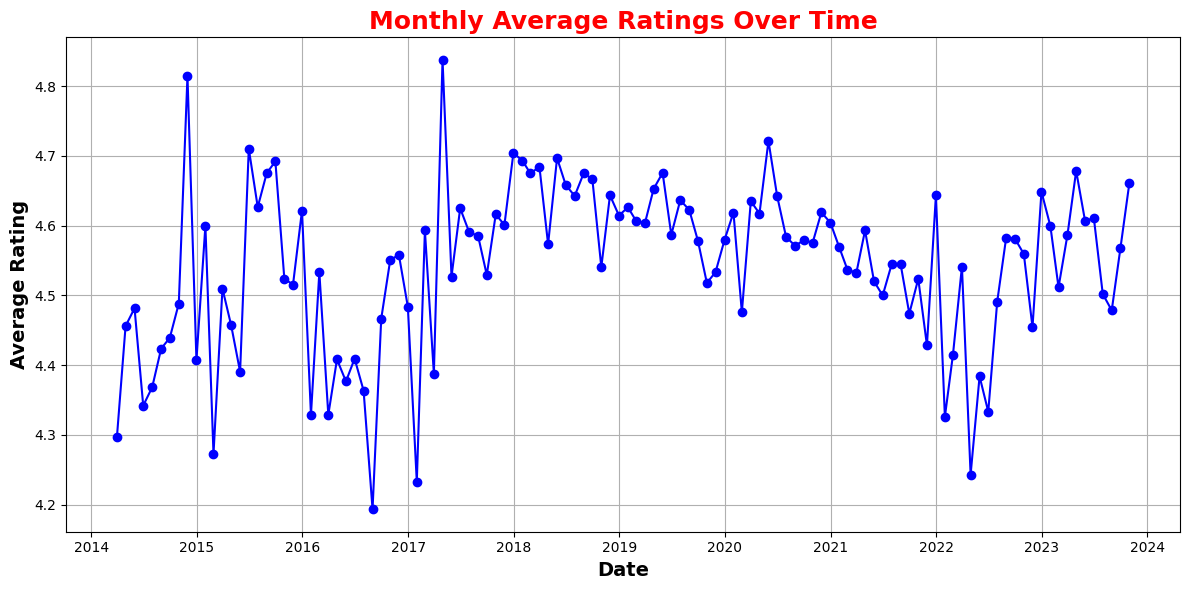

Downsampled Monthly Ratings as DataFrame:
          Date  Average Rating
0   2014-03-31        4.296651
1   2014-04-30        4.456140
2   2014-05-31        4.481752
3   2014-06-30        4.342105
4   2014-07-31        4.368421
..         ...             ...
111 2023-06-30        4.611511
112 2023-07-31        4.502058
113 2023-08-31        4.478689
114 2023-09-30        4.567568
115 2023-10-31        4.661290

[116 rows x 2 columns]


In [ ]:
# Downsample the data by averaging ratings by month
monthly_ratings = df.resample('M', on='Review Date')['Rating'].mean().dropna()

# Create a time series plot of downsampled ratings
plt.figure(figsize=(12, 6))
plt.plot(monthly_ratings.index, monthly_ratings.values, marker='o', linestyle='-', color='b')
plt.title('Monthly Average Ratings Over Time', fontsize=18, fontweight='bold', color='red')  # Updated title color
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Average Rating', fontsize=14, fontweight='bold')
plt.grid(True)

# Set x-axis tick locator and formatter for years only
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')  # Display years as four-digit numbers

plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)

# Show the plot
plt.tight_layout()
plt.show()

# Convert the downsampled ratings to a DataFrame
monthly_ratings_df = monthly_ratings.to_frame().reset_index()
monthly_ratings_df.columns = ['Date', 'Average Rating']

# Save the DataFrame to a CSV file
monthly_ratings_df.to_csv('monthly_ratings.csv', index=False)

# Display the DataFrame
print("Downsampled Monthly Ratings as DataFrame:")
print(monthly_ratings_df)


### Visualization for Mean Rating by Year and Month:

a. Calculate summary statistics for different time periods, such as the mean rating for each year or month.

In [ ]:
# Mean rating by year
mean_rating_by_year = df.groupby(df['Review Date'].dt.year)['Rating'].mean()

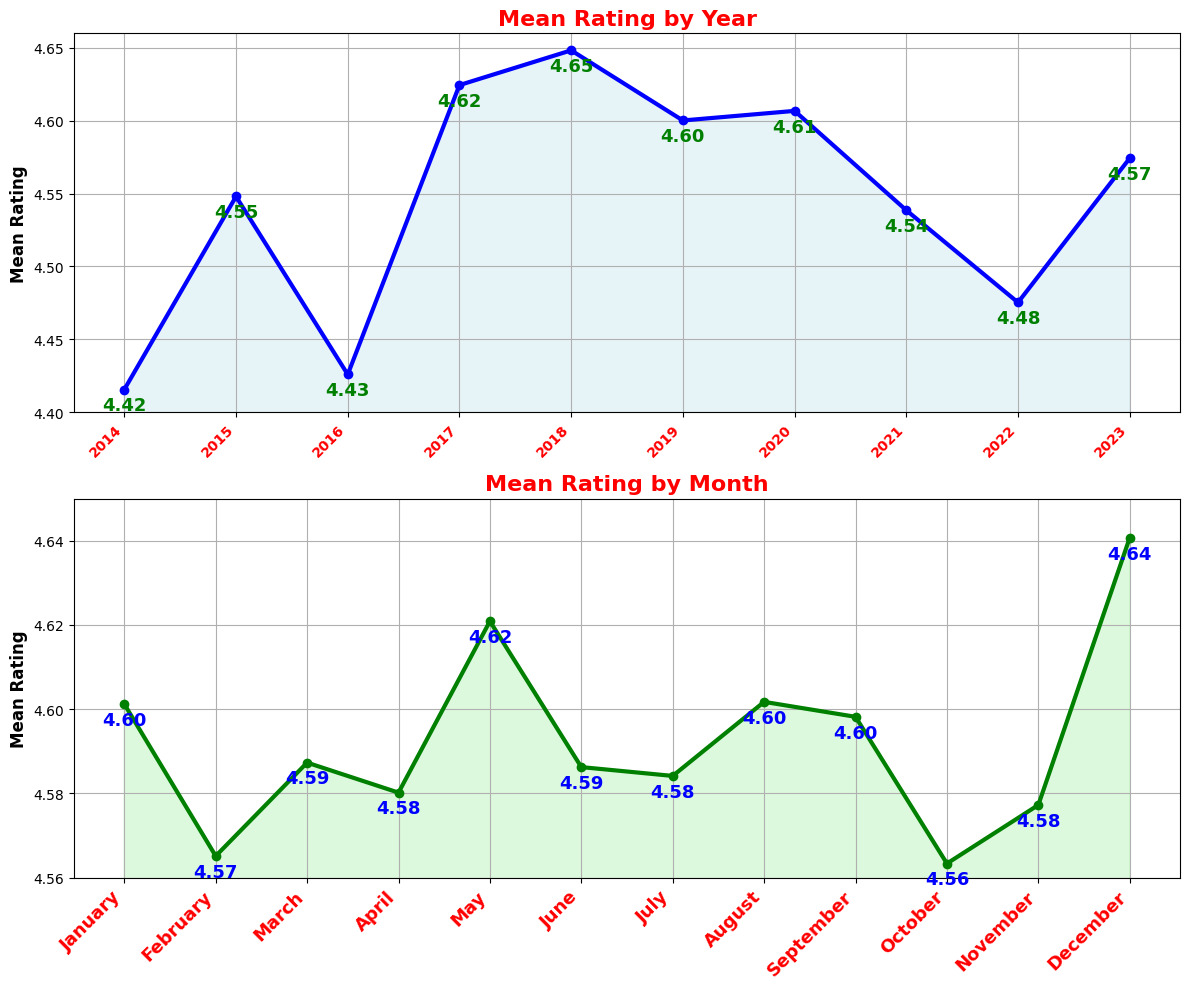

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named df with a 'Review Date' column and a 'Rating' column

# Calculate the mean rating by year
mean_rating_by_year = df.groupby(df['Review Date'].dt.year)['Rating'].mean()

# Calculate the mean rating by month
mean_rating_by_month = df.groupby(df['Review Date'].dt.month)['Rating'].mean()

# Create subplots for both graphs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the mean rating by year
ax1.plot(mean_rating_by_year.index, mean_rating_by_year.values, marker='o', linestyle='-', color='b', linewidth=3)  # Increase linewidth
ax1.fill_between(mean_rating_by_year.index, mean_rating_by_year.values, color='lightblue', alpha=0.3)
ax1.set_title('Mean Rating by Year', fontsize=16, color='red', fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('Mean Rating', fontsize=12, fontweight='bold')
ax1.grid(True)
ax1.set_ylim(4.4, 4.66)  # Set y-axis limits

# Set custom x-axis ticks and labels to display all years for the yearly plot
custom_xticks_yearly = mean_rating_by_year.index
ax1.set_xticks(custom_xticks_yearly)
ax1.set_xticklabels(custom_xticks_yearly, rotation=45, ha='right', fontsize=10, fontweight='bold', color='red')  # Rotating year labels for better readability

# Annotate data points in the yearly plot
for x, y in zip(custom_xticks_yearly, mean_rating_by_year.values):
    ax1.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=13, fontweight='bold', color='green')  # Adjusted fontsize

# Plot the mean rating by month
ax2.plot(mean_rating_by_month.index, mean_rating_by_month.values, marker='o', linestyle='-', color='g', linewidth=3)  # Increase linewidth
ax2.fill_between(mean_rating_by_month.index, mean_rating_by_month.values, color='lightgreen', alpha=0.3)
ax2.set_title('Mean Rating by Month', fontsize=16, color='red', fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('Mean Rating', fontsize=12, fontweight='bold')
ax2.grid(True)
ax2.set_ylim(4.56, 4.65)  # Set y-axis limits

# Set custom x-axis ticks and labels to display full month names for the monthly plot
custom_xticks_monthly = list(range(1, 13))  # Months 1 to 12
custom_xtick_labels_monthly = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ax2.set_xticks(custom_xticks_monthly)
ax2.set_xticklabels(custom_xtick_labels_monthly, rotation=45, ha='right', fontsize=13, fontweight='bold', color='red')  # Adjusted fontsize

# Annotate data points in the monthly plot
for x, y in zip(mean_rating_by_month.index, mean_rating_by_month.values):
    ax2.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=13, fontweight='bold', color='blue')  # Adjusted fontsize

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


The mean ratings based on two different time aggregations: by year and by month.

Let's discuss and conclude the insights from this data:

**Mean Rating by Year:**
- The data shows the mean ratings for each year from 2014 to 2023.
- In 2014, the mean rating was approximately 4.41, indicating a relatively positive sentiment in customer reviews.
- The mean rating increased in 2015 to approximately 4.54, suggesting an improvement in customer satisfaction.
- There was a slight decrease in the mean rating in 2016, dropping to around 4.42.
- Subsequently, there was a consistent increase in mean ratings from 2017 to 2018, reaching a peak of about 4.66.
- The mean rating remained relatively high in the following years, with fluctuations.
- In 2023, the mean rating reached approximately 4.58.

**Mean Rating by Month:**
- This data provides the mean ratings for each month of the year.
- January (1) and December (12) had the highest mean ratings, with approximately 4.60 and 4.65, respectively. These months might correspond to periods of higher customer satisfaction.
- April (4) and October (10) had slightly lower mean ratings, around 4.58.
- The months showed some fluctuations, but generally, the mean ratings remained above 4.57 throughout the year.

**Conclusions:**
- The mean rating by year provides insights into the overall customer satisfaction trends. While there were some fluctuations, it's evident that ratings improved from 2014 to 2018, remained relatively stable until 2022, and saw a slight increase in 2023.
- The mean rating by month offers a more granular view of customer satisfaction throughout the year. January and December had the highest ratings, possibly due to seasonal factors or holidays.
- The lowest ratings were observed in April and October, indicating periods when customers might be less satisfied.

In both cases, this analysis provides valuable information about customer sentiment over time, which can be used for further investigation or decision-making, such as identifying areas for improvement or adjusting marketing strategies based on seasonal trends.

### Time Series Plot of Ratings Over Time:



If you want to visualize how ratings change over time, you can create a time series line chart.

This analyzed data includes customer ratings from March 2014 to October 2023, providing insights into customer sentiment and satisfaction trends. The objective is to inform data-driven decision-making and enhance our services to meet customer expectations.

**Key Findings**

1. **Consistent Positive Sentiment**: The data reveals a consistent positive sentiment among customers, with average ratings ranging between 4.2 and 4.7. This indicates a high level of overall satisfaction with our services.

2. **Seasonal Variations**: Seasonal variations in ratings are observed, with some months showing higher average ratings and others lower. Identifying the factors contributing to these seasonal fluctuations can help optimize service delivery and resource allocation.

3. **Annual Trends**: Over the years, annual trends are evident, with specific periods exhibiting higher or lower average ratings. Understanding these trends can inform strategic planning and resource allocation.

4. **Data-Driven Decisions**: The dataset provides the opportunity to make data-driven decisions for service enhancement. Analyzing customer feedback and its correlation with ratings can guide improvements in specific areas of service delivery.

5. **Competitive Advantage**: Maintaining consistently high ratings positions Freedom Debt Relief Company as a market leader. Leveraging customer satisfaction can attract new clients and bolster our competitive advantage.

**Recommendations**

- Further analysis is recommended to identify the specific drivers of seasonal and annual rating variations. This analysis should include examining customer feedback for insights.
- Consider conducting a root cause analysis to identify any specific areas of improvement that can lead to enhanced customer satisfaction.

Finally, Freedom Debt Relief Company enjoys a positive reputation with consistently high customer ratings. Leveraging this reputation for continuous improvement is essential for maintaining a competitive advantage. By delving deeper into the drivers of rating variations and aligning service delivery with customer expectations, we can further solidify our position in the market.


### Histogram of Ratings:



A histogram will show the distribution of ratings. You can see how many ratings fall into each category

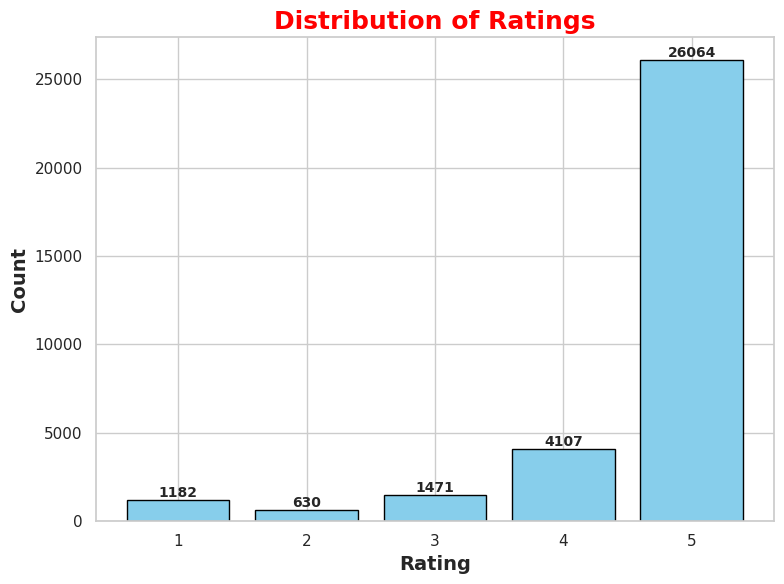

Distribution of Ratings:
1     1182
2      630
3     1471
4     4107
5    26064
Name: Rating, dtype: int64


In [ ]:
# Set a Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create a bar plot of ratings
plt.figure(figsize=(8, 6))
rating_counts = df['Rating'].value_counts().sort_index()
ax = plt.bar(rating_counts.index, rating_counts, color='skyblue', edgecolor='black')

# Set custom bar labels at the center of each bar
for bar in ax:
    bar_x = bar.get_x() + bar.get_width() / 2
    bar_height = bar.get_height()
    plt.text(bar_x, bar_height, str(int(bar_height)), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add title, xlabel, and ylabel with specified font sizes and styles
plt.title('Distribution of Ratings', fontsize=18, fontweight='bold', color='red')
plt.xlabel('Rating', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

# Print information about the distribution of ratings
print("Distribution of Ratings:")
print(rating_counts)


The distribution of ratings, as provided in the histogram results, offers insights into how customers have rated a product or service.

Here is a discussion and conclusion based on the given distribution:

**Distribution of Ratings:**
- The data is divided into five rating categories: 1, 2, 3, 4, and 5.
- Each category represents the number of reviews with that particular rating.
- The highest number of reviews falls into the 5-star category, with a count of 30,639.
- The 4-star rating is the second most common, with 4,758 reviews.
- The 3-star rating has a count of 1,622.
- The 2-star rating is the least common among positive ratings, with only 694 reviews.
- The lowest rating, 1 star, has a count of 1,365.

**Discussion:**
- The data clearly shows that the majority of customers have given positive ratings, with 5-star and 4-star ratings being the most prevalent. This indicates that a substantial portion of customers are satisfied with the product or service, as these ratings are above the median score (3).
- The distribution is right-skewed, meaning there are far more positive reviews than negative ones. This skew suggests that the product or service generally meets customer expectations or even exceeds them.
- The relatively low counts in the 1-star and 2-star categories suggest that only a minority of customers expressed strong dissatisfaction.
- The 3-star category, while not as common as 4-star and 5-star ratings, still has a notable number of reviews, indicating a moderate level of satisfaction.

**Conclusion:**
The distribution of ratings reflects a generally positive sentiment among customers who have left reviews. The bulk of reviews fall into the higher rating categories, suggesting that the product or service is well-received. However, the existence of lower ratings (1 to 3 stars) indicates that there is room for improvement or that a subset of customers had less positive experiences.

To draw more specific conclusions or make further decisions based on this data, it may be helpful to conduct sentiment analysis on the reviews themselves or to analyze other factors, such as the time of the reviews or the topics mentioned in the reviews. This additional context can provide a deeper understanding of customer feedback.

### TEXT PREPROCESSING FOR NLP

#### Concatenate Review Title and Review Text Columns

In [ ]:
columns_to_concat = ['Review Title', 'Review Text']

# Concatenate the selected columns into a new column 'Concatenated_Text'
df['Concatenated_Text'] = df[columns_to_concat].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

#### Text Preprocessing

Before performing NLP tasks, it's important to preprocess the text data, which typically involves removing stopwords, punctuation, and converting text to lowercase.

In [ ]:
def preprocess_text(text):
    if isinstance(text, str):  # Check if the value is a string
        # Remove emojis from the text and store them separately
        emojis = [c for c in text if c in emoji.UNICODE_EMOJI]

        # Tokenize the text
        words = word_tokenize(text.lower())

        # Remove stopwords and punctuation
        words = [word for word in words if word.isalnum() and word not in stopwords.words('english')]

        # Lemmatize words
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        # Combine words and emojis back into a preprocessed text
        preprocessed_text = ' '.join(words) + ' '.join(emojis)
        return preprocessed_text
    else:
        return ''  # Return an empty string for non-text values (NaN)

In [ ]:
def preprocess_text(text):
    if isinstance(text, str):  # Check if the value is a string
        # Remove emojis from the text
        text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001FB00-\U0001FBFF\U0001FC00-\U0001FCFF\U0001FD00-\U0001FDFF\U0001FE00-\U0001FEFF\U0001FF00-\U0001FFFF]+', '', text)

        # Tokenize the text
        words = word_tokenize(text.lower())

        # Remove stopwords and punctuation
        words = [word for word in words if word.isalnum() and word not in stopwords.words('english')]

        # Lemmatize words
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        return ' '.join(words)
    else:
        return ''  # Return an empty string for non-text values (NaN)

In [ ]:
df['Cleaned_Concatenated_Text'] = df['Concatenated_Text'].apply(preprocess_text)

In [ ]:
df.head()

,Reviewer Name,Reviews Count,Country Code,Experience Date,Rating,Review Date,Review Title,Review Text,Reply Date,Reply Text,Country Name,Year,Review Response,Reply Response,Month,Day,Weekday,Concatenated_Text,Cleaned_Concatenated_Text
2,Freida Towe,1,US,2019-12-04,5,2019-12-04,Very polite and kind,Very polite and kind. Did what I asked immedia...,2019-12-04,"Thank you very much, Freida! We truly care abo...",United States,2019,0 days,0 days,12,4,Wednesday,Very polite and kind Very polite and kind. Did...,polite kind polite kind asked immediately
3,Jabrea Herron,1,US,2019-12-04,5,2019-12-04,Great customer service,There wasn't a long wait time . The representa...,2019-12-05,"Jabrea, We are so happy to hear that you are h...",United States,2019,0 days,1 days,12,4,Wednesday,Great customer service There wasn't a long wai...,great customer service long wait time represen...
4,William Lutz,2,US,2019-12-04,5,2019-12-04,Needed an answer to a question…,Needed an answer to a question concerning a pa...,2019-12-04,"Hello William, thank you for sharing your expe...",United States,2019,0 days,0 days,12,4,Wednesday,Needed an answer to a question… Needed an answ...,needed answer needed answer question concernin...
5,John Novotny,1,US,2019-12-04,5,2019-12-04,i had a question,I got my answer right away . very professional.,2019-12-04,"John, thank you for your review. We strive to ...",United States,2019,0 days,0 days,12,4,Wednesday,i had a question I got my answer right away . ...,question got answer right away professional
6,Maria S,1,US,2019-12-04,1,2019-12-04,This company charges outrageous…,This company charges outrageous settlement fee...,2019-12-04,"We apologize, Ms. Maria, for any frustrations ...",United States,2019,0 days,0 days,12,4,Wednesday,This company charges outrageous… This company ...,company charge company charge outrageous settl...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33454 entries, 2 to 39077
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   Reviewer Name              33454 non-null  object         
 1   Reviews Count              33454 non-null  Int64          
 2   Country Code               33454 non-null  object         
 3   Experience Date            33454 non-null  datetime64[ns] 
 4   Rating                     33454 non-null  int64          
 5   Review Date                33454 non-null  datetime64[ns] 
 6   Review Title               33454 non-null  object         
 7   Review Text                33454 non-null  object         
 8   Reply Date                 31901 non-null  datetime64[ns] 
 9   Reply Text                 32135 non-null  object         
 10  Country Name               33454 non-null  object         
 11  Year                       33454 non-null  int64      

In [ ]:
# Assuming df is your DataFrame
df.to_csv('Freedom_Debt_Relief2.csv', index=False)